# GBSV MC2: 2D Images

## General set-up and introduction to the country

All the code will be uploaded in my github: https://github.com/AntoniaBonfa/GBSV_FS25_MC1 

### Country: Polynesia
For my country, I am sticking with Polynesia as I have a lot of beautiful pictures and memories from there. Polynesia consists of numerous islands across multiple archipels, though I mainly stayed on the main society island group. I will also be including an object from Rarotonga, which, while still polynesian, is part of the Cook Islands and thus not politically the same as French Polynesia. But culturally all the islands in the pacific are very close. 



In [20]:
# general imports
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from pygments.formatters import img
from scipy import ndimage

# Import images
marae = cv.imread('images/marae.jpg') 
marae = cv.cvtColor(marae, cv.COLOR_BGR2RGB)

fruits = cv.imread('images/fruits.jpg')
fruits = cv.cvtColor(fruits, cv.COLOR_BGR2RGB)





In [3]:
def plot_img_with_hist(img, cmap='gray', bins=255, xlim_min=0, xlim_max=255):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    axs[0].imshow(img, cmap=cmap)
    axs[0].axis('off')
    axs[0].set_title("Image")
    axs[1].hist(img.flatten(), bins=bins)
    axs[1].set_xlim(xlim_min,xlim_max)
    axs[1].set_title("Histogram")
    plt.tight_layout()
    plt.show()
    
def plot_color_img_with_hist(img):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Show the image
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title("Image")

    # Plot histograms for each channel
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        axs[1].hist(img[:, :, i].flatten(), bins=255, color=color, alpha=0.6, label=f'{color.upper()} channel')
    
    axs[1].set_xlim(0, 255)
    axs[1].set_title("Histogram (RGB)")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


## 2.1: Algorithms for pattern detection (Days 1-4)

#### Day 1: Choose pattern & Algorithm

For the first part of the challenge, I chose an image of a "Marae". These were sites for rituals and ceremonies before the arrival of christians with their churches. The image depicts Marae Manunu on Huahine, which was devoted to Tane, the god of war and fish, as well as the god Ore. The whole thing is built mainly from coral and was only reconstructed in the 1960s. 
The image shows an etching which can be found on one of the walls: according to what my guide told me, it's supposed to be a turtle. Unfortunately the etching is not very well visible, which is why I will try to use algorithms to find lines to make the drawing more visible.  

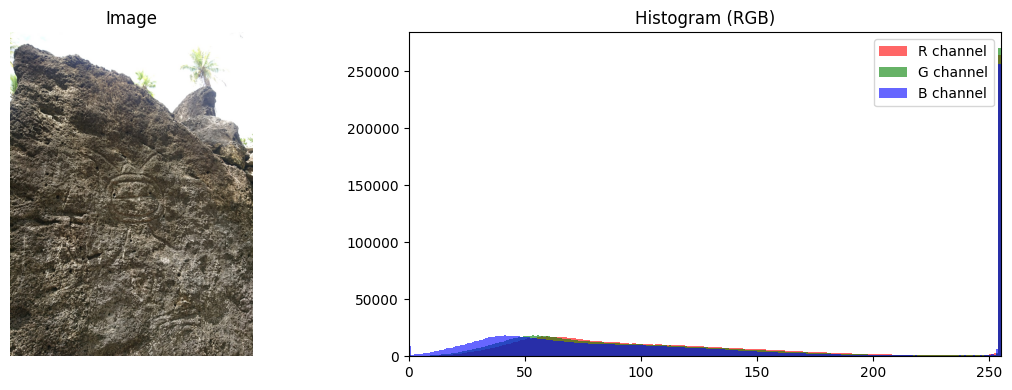

In [4]:
plot_color_img_with_hist(marae)

As we can see, the intensities of the image are all fairly similar. Given that it's mainy grey with one white corner that makes sense. As I am interested in the etching, I will implment the Canny Edge Detection algorithm as it's supposed to handle noise well and give clean edges. 


In [14]:
#Step 1: blurring
def apply_gaussian_blur(image, kernel = (7,7), sigma=1.0):
    blurred_image = cv.GaussianBlur(image, kernel, sigma)
    return blurred_image

# Step 2+3: Compute gradient Magnitude & Direction 
def compute_gradients(blurred_image):
    """
    Compute gradients in x and y directions using Sobel operators.
    Returns gradient magnitude and direction.
    """
    # Compute the gradients in the x and y directions
    grad_x = ndimage.sobel(blurred_image, axis=1)
    grad_y = ndimage.sobel(blurred_image, axis=0)
    
    # Compute gradient magnitude and direction
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    gradient_direction = np.arctan2(grad_y, grad_x)
    
    return gradient_magnitude, gradient_direction

# Step 4: Non-maximum suppression
def non_maximum_suppression(gradient_magnitude, gradient_direction):
    degrees = np.degrees(gradient_direction) % 180
    suppressed = np.zeros_like(gradient_magnitude)
    
    M, N = gradient_magnitude.shape
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            # Check the neighbors based on gradient direction
            if (0 <= degrees[i, j] < 22.5) or (157.5 <= degrees[i, j] <= 180):
                # Horizontal direction
                neighbors = [gradient_magnitude[i, j-1], gradient_magnitude[i, j+1]]
            elif 22.5 <= degrees[i, j] < 67.5:
                # Diagonal direction (/)
                neighbors = [gradient_magnitude[i-1, j-1], gradient_magnitude[i+1, j+1]]
            elif 67.5 <= degrees[i, j] < 112.5:
                # Vertical direction
                neighbors = [gradient_magnitude[i-1, j], gradient_magnitude[i+1, j]]
            else:  # 112.5 <= angle < 157.5
                # Diagonal direction (\)
                neighbors = [gradient_magnitude[i-1, j+1], gradient_magnitude[i+1, j-1]]
            
            # If the current pixel is a local maximum, keep it
            if gradient_magnitude[i, j] >= max(neighbors):
                suppressed[i, j] = gradient_magnitude[i, j]
    
    return suppressed

# Step 5: Double thresholding
def double_thresholding(suppressed, low_threshold_ratio=0.05, high_threshold_ratio=0.15):
    high_threshold = suppressed.max() * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio
    thresholded = np.zeros_like(suppressed)
    
    strong_i, strong_j = np.where(suppressed >= high_threshold)
    weak_i, weak_j = np.where((suppressed >= low_threshold) & (suppressed < high_threshold))
    
    thresholded[strong_i, strong_j] = 2  # Strong edges
    thresholded[weak_i, weak_j] = 1      # Weak edges
    
    return thresholded, low_threshold, high_threshold

# Step 6: Hysteresis
def hysteresis(thresholded):
    M, N = thresholded.shape
    
    strong_i, strong_j = np.where(thresholded == 2)
    
    edges = np.zeros_like(thresholded)
    edges[strong_i, strong_j] = 1  
    
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    
    while len(strong_i) > 0:
        i, j = strong_i[0], strong_j[0]
        strong_i, strong_j = strong_i[1:], strong_j[1:]
        
        for di, dj in neighbors:
            ni, nj = i + di, j + dj
            if (0 <= ni < M and 0 <= nj < N and 
                thresholded[ni, nj] == 1 and edges[ni, nj] == 0):
                edges[ni, nj] = 1
                strong_i = np.append(strong_i, ni)
                strong_j = np.append(strong_j, nj)
    
    return edges

def canny_edge_detector(image,kernel = (7,7), sigma=1.0, low_threshold_ratio=0.05, high_threshold_ratio=0.15):
    """
    Full Canny edge detection pipeline.
    Returns all intermediate results for demonstration.
    """
    results = {}
    results['original'] = image
    
    if image is None:
        return None
    
    # Step 2: Apply Gaussian blur
    blurred = apply_gaussian_blur(image, kernel,sigma)
    results['blurred'] = blurred
    
    # Step 3: Compute gradient magnitude & Direction
    gradient_magnitude, gradient_direction = compute_gradients(blurred)
    results['gradient_magnitude'] = gradient_magnitude
    results['gradient_direction'] = gradient_direction
    
    # Step 4: Non-maximum suppression
    suppressed = non_maximum_suppression(gradient_magnitude, gradient_direction)
    results['suppressed'] = suppressed
    
    # Step 5: Double thresholding
    thresholded, low_threshold, high_threshold = double_thresholding(
        suppressed, low_threshold_ratio, high_threshold_ratio
    )
    results['thresholded'] = thresholded
    results['low_threshold'] = low_threshold
    results['high_threshold'] = high_threshold
    
    # Step 6: Hysteresis
    edges = hysteresis(thresholded)
    results['edges'] = edges
    
    return results

def display_results(results):
    """
    Display all intermediate results of the Canny edge detection.
    """
    if results is None:
        print("No results to display.")
        return
    
    # Define which results to plot
    plot_items = [
        ('original', 'Original Image'),
        ('blurred', 'Gaussian Blur'),
        ('gradient_magnitude', 'Gradient Magnitude'),
        ('gradient_direction', 'Gradient Direction'),
        ('suppressed', 'Non-Maximum Suppression'),
        ('thresholded', 'Double Thresholding'),
        ('edges', 'Final Edges (Hysteresis')
    ]
    
    plt.figure(figsize=(15, 10))
    for i, (key, title) in enumerate(plot_items, 1):
        plt.subplot(2, 4, i)
        
        if key in results:
            if key == 'gradient_direction':
                plt.imshow(results[key], cmap='hsv')
            else:
                plt.imshow(results[key], cmap='gray')
                
            plt.title(title)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    

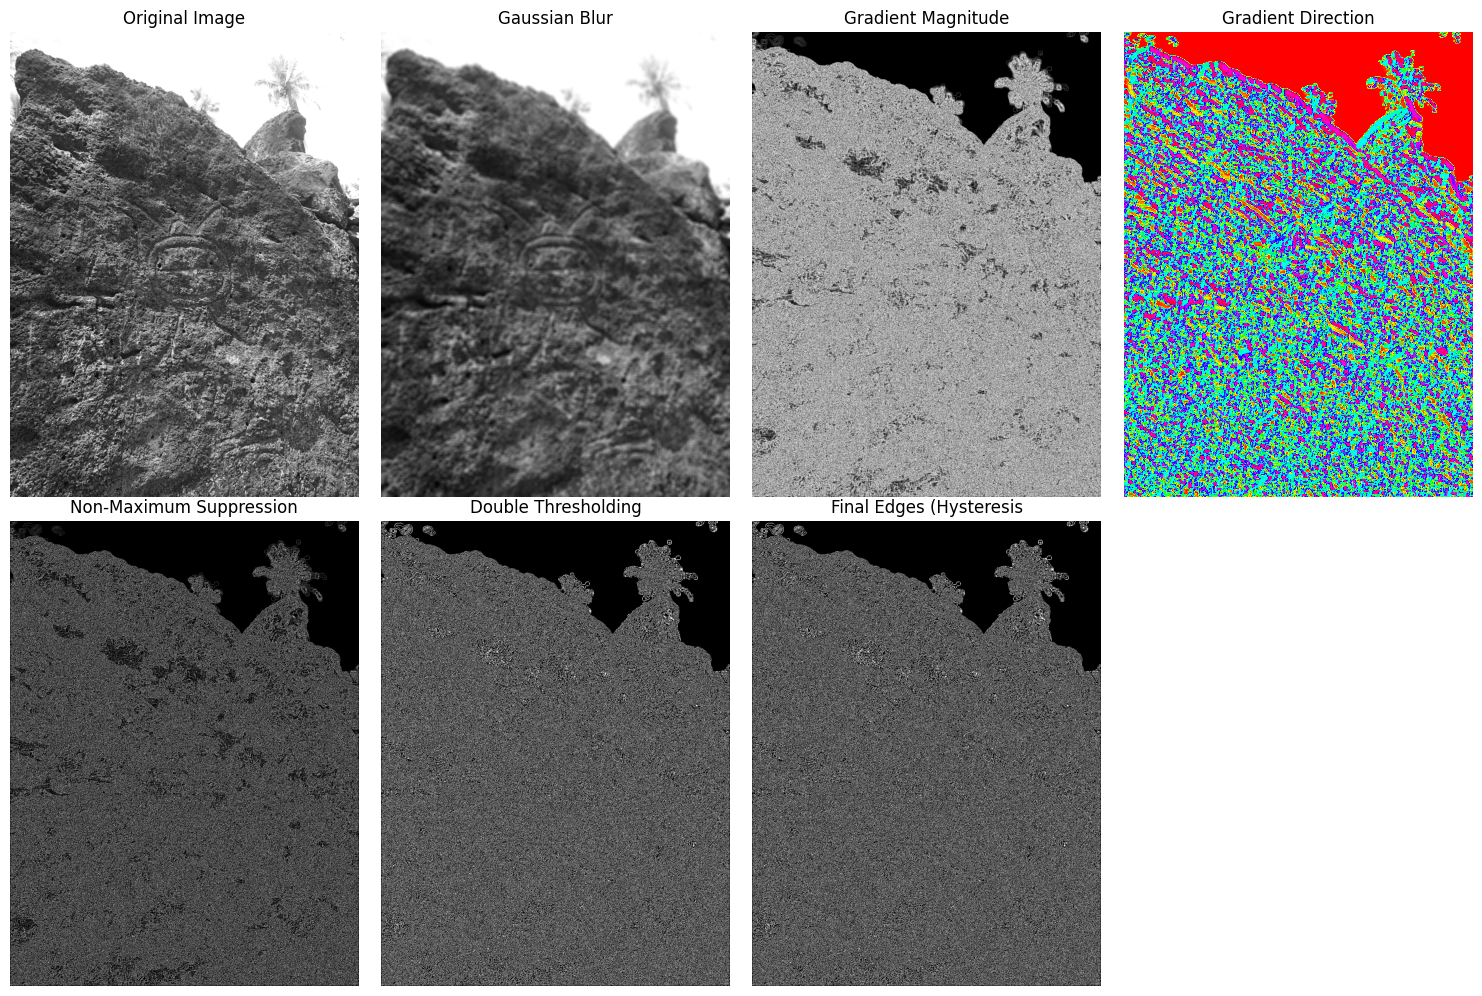

In [16]:
gray = cv.cvtColor(marae, cv.COLOR_RGB2GRAY)
results = canny_edge_detector(gray, kernel=(13,13), sigma =15)
display_results(results)


## Sources:
#### Images
all by myself

#### Information about Polynesia:
Marae Manunu: https://www.tahitiheritage.pf/marae-manunu-maeva